In [1]:
import numpy as np
import cupy as cp
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from numba import njit
import time


In [2]:
@njit
def mirror_cpu(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = np.zeros((nlin, ncol), dtype=A.dtype)

    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]

    return B


In [3]:
@njit
def NLM_fast_cpu(img, h, f, t):
    m, n = img.shape
    filtrada = np.zeros((m, n), dtype=img.dtype)
    img_n = mirror_cpu(img, f)
    for i in range(m):
        for j in range(n):
            im = i + f
            jn = j + f
            W1 = img_n[im-f:im+f+1, jn-f:jn+f+1]
            rmin = max(im-t, f)
            rmax = min(im+t, m+f-1)
            smin = max(jn-t, f)
            smax = min(jn+t, n+f-1)
            NL = 0.0
            Z = 0.0
            for r in range(rmin, rmax+1):
                for s in range(smin, smax+1):
                    W2 = img_n[r-f:r+f+1, s-f:s+f+1]
                    d2 = np.sum((W1 - W2)**2)
                    sij = np.exp(-d2/(h**2))
                    Z += sij
                    NL += sij * img_n[r, s]
            filtrada[i, j] = NL / Z
    return filtrada


In [4]:
def mirror_gpu(A, f):
    n, m = A.shape
    B = cp.zeros((n + 2*f, m + 2*f), dtype=A.dtype)
    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]
    return B


In [5]:
nlm_kernel_global_code = r'''
extern "C" __global__
void nlm_kernel_global(
    const float* img_n, float* output,
    int m, int n, int f, int t, float h, int padded_width
) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= m || j >= n)
        return;

    int im = i + f;
    int jm = j + f;

    float NL = 0.0f;
    float Z = 0.0f;

    for (int r = im - t; r <= im + t; ++r) {
        for (int s = jm - t; s <= jm + t; ++s) {
            float d2 = 0.0f;
            for (int u = -f; u <= f; ++u) {
                for (int v = -f; v <= f; ++v) {
                    int x1 = im + u;
                    int y1 = jm + v;
                    int x2 = r + u;
                    int y2 = s + v;

                    float val1 = img_n[x1 * padded_width + y1];
                    float val2 = img_n[x2 * padded_width + y2];
                    float diff = val1 - val2;
                    d2 += diff * diff;
                }
            }
            float weight = __expf(-d2 / (h * h));
            Z += weight;
            NL += weight * img_n[r * padded_width + s];
        }
    }

    output[i * n + j] = NL / Z;
}
'''



In [6]:
def NLM_fast_cuda_global(img, h, f, t):
    img = img.astype(cp.float32)
    m, n = img.shape
    padded = mirror_gpu(img, f)

    module = cp.RawModule(code=nlm_kernel_global_code, options=('-std=c++11',))
    kernel = module.get_function("nlm_kernel_global")

    output = cp.zeros((m, n), dtype=cp.float32)
    threads_per_block = (16, 16)
    grid = ((n + 15) // 16, (m + 15) // 16)

    kernel(
        grid, threads_per_block,
        (
            padded.ravel(), output.ravel(),
            cp.int32(m), cp.int32(n), cp.int32(f), cp.int32(t),
            cp.float32(h), cp.int32(padded.shape[1])
        )
    )

    return output


Tempo CPU: 7.699819564819336
Tempo GPU: 0.10957574844360352
Diferença média: 0.0164
Diferença máxima: 4.9686

--- Métricas de Qualidade ---
PSNR (CPU NLM):  33.28 dB
PSNR (CUDA NLM): 33.28 dB
SSIM (CPU NLM):  0.9126
SSIM (CUDA NLM): 0.9126


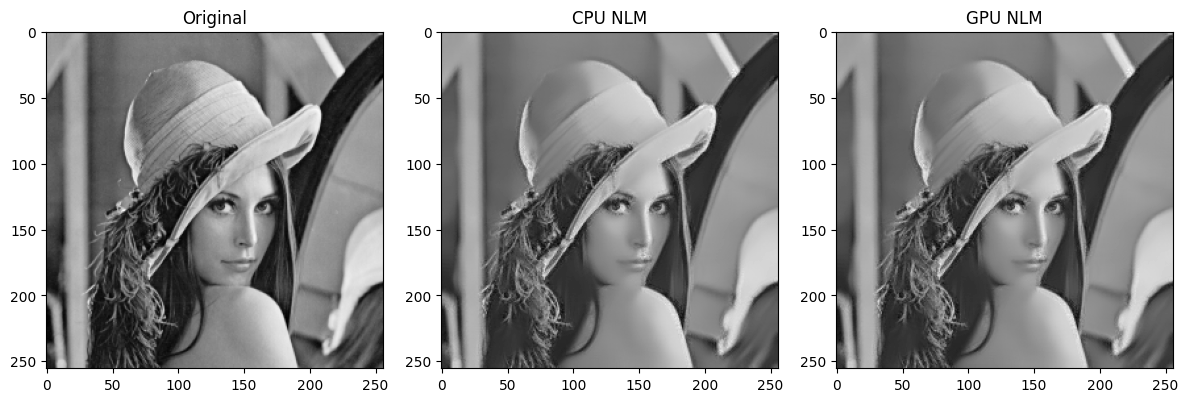

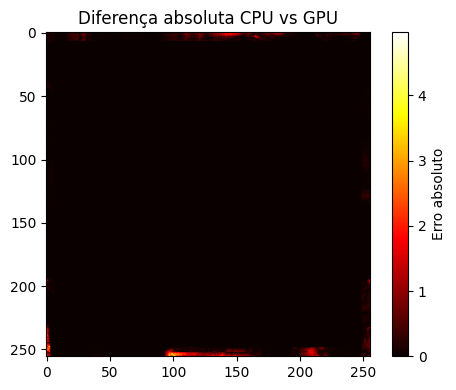

In [8]:
# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape
sigma = 10
ruido = np.random.normal(0, sigma, (m, n)).astype(np.float32)
ruidosa = np.clip(img_downscale + ruido, 0, 255)

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
img_gpu = cp.array(img_cpu)

# Parâmetros do filtro
h = 110
f = 4
t = 7

# ------------------------------- CPU -------------------------------
start_cpu = time.time()
result_cpu = NLM_fast_cpu(img_cpu, h, f, t)
print("Tempo CPU:", time.time() - start_cpu)

# ------------------------------- GPU -------------------------------
start_gpu = time.time()
result_gpu = NLM_fast_cuda_global(img_gpu, h, f, t)
cp.cuda.Stream.null.synchronize()
print("Tempo GPU:", time.time() - start_gpu)

# Comparação
result_gpu_cpu = cp.asnumpy(result_gpu)
diff = np.abs(result_cpu - result_gpu_cpu)
print(f'Diferença média: {diff.mean():.4f}')
print(f'Diferença máxima: {diff.max():.4f}')

# Métricas PSNR e SSIM em relação à imagem original
img_ref = np.clip(img_downscale, 0, 255).astype(np.uint8)
result_cpu_uint8 = np.clip(result_cpu, 0, 255).astype(np.uint8)
result_gpu_uint8 = np.clip(result_gpu_cpu, 0, 255).astype(np.uint8)

psnr_cpu = peak_signal_noise_ratio(img_ref, result_cpu_uint8, data_range=255)
psnr_gpu = peak_signal_noise_ratio(img_ref, result_gpu_uint8, data_range=255)
ssim_cpu = structural_similarity(img_ref, result_cpu_uint8, data_range=255)
ssim_gpu = structural_similarity(img_ref, result_gpu_uint8, data_range=255)

print(f'\n--- Métricas de Qualidade ---')
print(f'PSNR (CPU NLM):  {psnr_cpu:.2f} dB')
print(f'PSNR (CUDA NLM): {psnr_gpu:.2f} dB')
print(f'SSIM (CPU NLM):  {ssim_cpu:.4f}')
print(f'SSIM (CUDA NLM): {ssim_gpu:.4f}')

# Visualizações
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img_ref, cmap='gray')
plt.subplot(1,3,2); plt.title("CPU NLM"); plt.imshow(result_cpu, cmap='gray')
plt.subplot(1,3,3); plt.title("GPU NLM"); plt.imshow(result_gpu_cpu, cmap='gray')
plt.tight_layout(); plt.show()

# Diferença absoluta entre CPU e GPU
plt.figure(figsize=(5,4))
plt.title("Diferença absoluta CPU vs GPU")
plt.imshow(diff, cmap='hot')
plt.colorbar(label='Erro absoluto')
plt.tight_layout()
plt.show()

In [28]:
from skimage.io import imsave
imsave("cpu_result.png", np.clip(result_cpu, 0, 255).astype(np.uint8))
imsave("gpu_result.png", np.clip(result_gpu_cpu, 0, 255).astype(np.uint8))
imsave("abs_diff.png", np.clip(diff * 10, 0, 255).astype(np.uint8))